In [232]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import truvari
import truvari.stats as ts
import pysam
import os
from pandas.api.types import CategoricalDtype
SZBINTYPE = CategoricalDtype(categories=ts.SZBINS, ordered=True)

In [218]:
TRUVARI_DIR = 'results_sv_multi/'
STATES = ['fp', 'fn', 'tp-base', 'tp-call']
TYPES = ['DUP', 'INS', 'DEL']

In [85]:
# Finds the correct bin for input
# Possible bins: ['[0,50)', '[50,100)', '[100,200)', '[200,300)', 
#                  '[300,400)','[400,600)', '[600,800)', '[800,1k)', 
#                  '[1k,2.5k)','[2.5k,5k)', '>=5k']
def getBin(val):
    bin_dict = {}
    for b in ts.SZBINS:
        if b[0] == '[':
            
            low_str = b.split(',')[0][1:]
            high_str = b.split(',')[1][:-1]
            
            if low_str[-1] == 'k':
                low = 1000*float(low_str[:-1])
            else:
                low = float(low_str)
                
            if high_str[-1] == 'k':
                high = 1000*float(high_str[:-1])
            else:
                high = float(high_str)
            
        else:
            low = 5000
            high = None
    
        if high and low <= val < high: return b
        if not high and low <= val: return b
    
    raise Exception("Not a valid bin value")

In [271]:
# creates a dataframe from all the vcfs in the Truvari directory
def getTruvariDF():
    dfs = []
    for state in STATES:
        file = os.path.join(TRUVARI_DIR, state + '.vcf.gz')
        v = pysam.VariantFile(file)
        rows = []
        for entry in v:        
            rows.append([state,
                         truvari.entry_variant_type(entry),  
                         truvari.entry_boundaries(entry)[0],
                         truvari.entry_boundaries(entry)[1],
                         truvari.entry_size(entry)])
        df = pd.DataFrame(rows, columns=["state","svtype","start", "end", "svlen"])
        df['szbin'] = df['svlen'].apply(getBin)
        df['szbin'] = df['szbin'].astype(SZBINTYPE)
        dfs.append(df)
    return pd.concat(dfs)

In [272]:
tdf = getTruvariDF()

In [210]:
def getPerformanceTable(tdf):

    measures = {}
    counts = tdf['state'].value_counts()
    tp_call = counts['tp-call']
    tp_base = counts['tp-base']
    tp = tp_call + tp_base
    fp = counts['fp']
    fn = counts['fn']
    precision = tp_call / (tp_call + fp)
    recall = tp_base / (tp_base + fn)
    f1 = 2*((recall * precision) / (recall + precision))

    measures['True Positives'] = tp
    measures['False Negatives'] = fn
    measures['False Positives'] = fp
    measures['Precision'] = precision
    measures['Recall'] = recall
    measures['F1'] = f1

    df = pd.DataFrame.from_dict(measures, orient='index', columns=['Value'])

    with pd.option_context('display.float_format', '{:0.2f}'.format):
        display(df)

In [211]:
getPerformanceTable(tdf)

,Value
True Positives,8441.00
False Negatives,5424.00
False Positives,375.00
Precision,0.92
Recall,0.44
F1,0.59


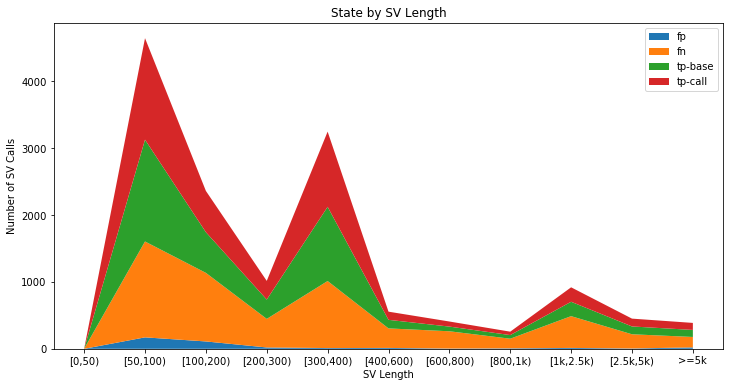

In [161]:
xs = ts.SZBINS
ys = []
for state in STATES:
    # gets the number of given state for each bin in increasing order
    ys.append(tdf[tdf['state']==state].groupby('szbin')['state'].count().sort_index().to_list())
    
# Plot
fig, axs = plt.subplots(figsize=(12,6))
plt.stackplot(xs,ys, labels=STATES)
axs.set_xticks(axs.get_xticks()[::1])
plt.legend(loc='upper right')
plt.title('State by SV Length')
plt.xlabel('SV Length')
plt.ylabel('Number of SV Calls')
plt.show()

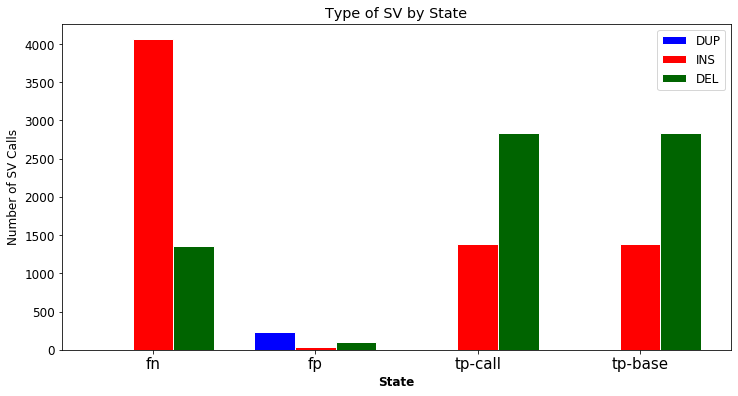

In [264]:
xs = TYPES
ys = []
for svtype in TYPES:
    count_dict = {'fn' : 0, 'fp' : 0, 'tp-call' : 0, 'tp-base' : 0}
    counts = tdf[tdf['svtype']==svtype]['state'].value_counts()
    for state in counts.index:
        count_dict[state] = count_dict[state] + counts[state]
    ys.append(list(count_dict.values())) 

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = ys[0]
bars2 = ys[1] 
bars3 = ys[2] 

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
fig, axs = plt.subplots(figsize=(12,6))
plt.bar(r1, bars1, color='blue', width=barWidth, edgecolor='white', label=TYPES[0])
plt.bar(r2, bars2, color='red', width=barWidth, edgecolor='white', label=TYPES[1])
plt.bar(r3, bars3, color='darkgreen', width=barWidth, edgecolor='white', label=TYPES[2])
 
# Add xticks on the middle of the group bars
plt.xlabel('State', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], count_dict.keys(), fontsize=15)

plt.ylabel('Number of SV Calls')
plt.title('Type of SV by State')

# Create legend & Show graphic
plt.legend()
plt.show()

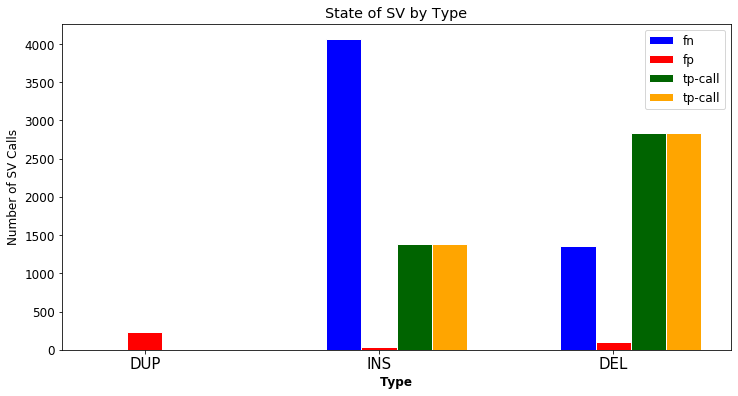

In [270]:
xs = TYPES
ys = []
for svtype in TYPES:
    count_dict = {'fn' : 0, 'fp' : 0, 'tp-call' : 0, 'tp-base' : 0}
    counts = tdf[tdf['svtype']==svtype]['state'].value_counts()
    for state in counts.index:
        count_dict[state] = count_dict[state] + counts[state]
    ys.append(list(count_dict.values())) 

# set width of bar
barWidth = 0.15

ys = list(map(list, zip(*ys)))
 
# set height of bar
bars1 = ys[0]
bars2 = ys[1] 
bars3 = ys[2]
bars4 = ys[3]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
fig, axs = plt.subplots(figsize=(12,6))
labels = list(count_dict.keys())
plt.bar(r1, bars1, color='blue', width=barWidth, edgecolor='white', label=labels[0])
plt.bar(r2, bars2, color='red', width=barWidth, edgecolor='white', label=labels[1])
plt.bar(r3, bars3, color='darkgreen', width=barWidth, edgecolor='white', label=labels[2])
plt.bar(r4, bars3, color='orange', width=barWidth, edgecolor='white', label=labels[2])
 
    
# Add xticks on the middle of the group bars
plt.xlabel('Type', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], TYPES, fontsize=15)

plt.ylabel('Number of SV Calls')
plt.title('State of SV by Type')

# Create legend & Show graphic
plt.legend()
plt.show()

################################ STOPPED HERE ###################################

In [4]:
def show_values_on_bars(axs, fmt='{:.2f}', buff=0, box=True, size=15):
    """ Given a barchart (seaborn or matplotlib), add values on top of bars
    c/o https://stackoverflow.com/a/51535326 """
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + buff
            value = fmt.format(p.get_height())
            t = ax.text(_x, _y, value, ha="center", size=size)
            if box:
                t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

<ipython-input-5-c0114a1bbdcb>:43: RuntimeWarning: invalid value encountered in double_scalars
  rows.append([i, j.name, k_lab, het/hom])


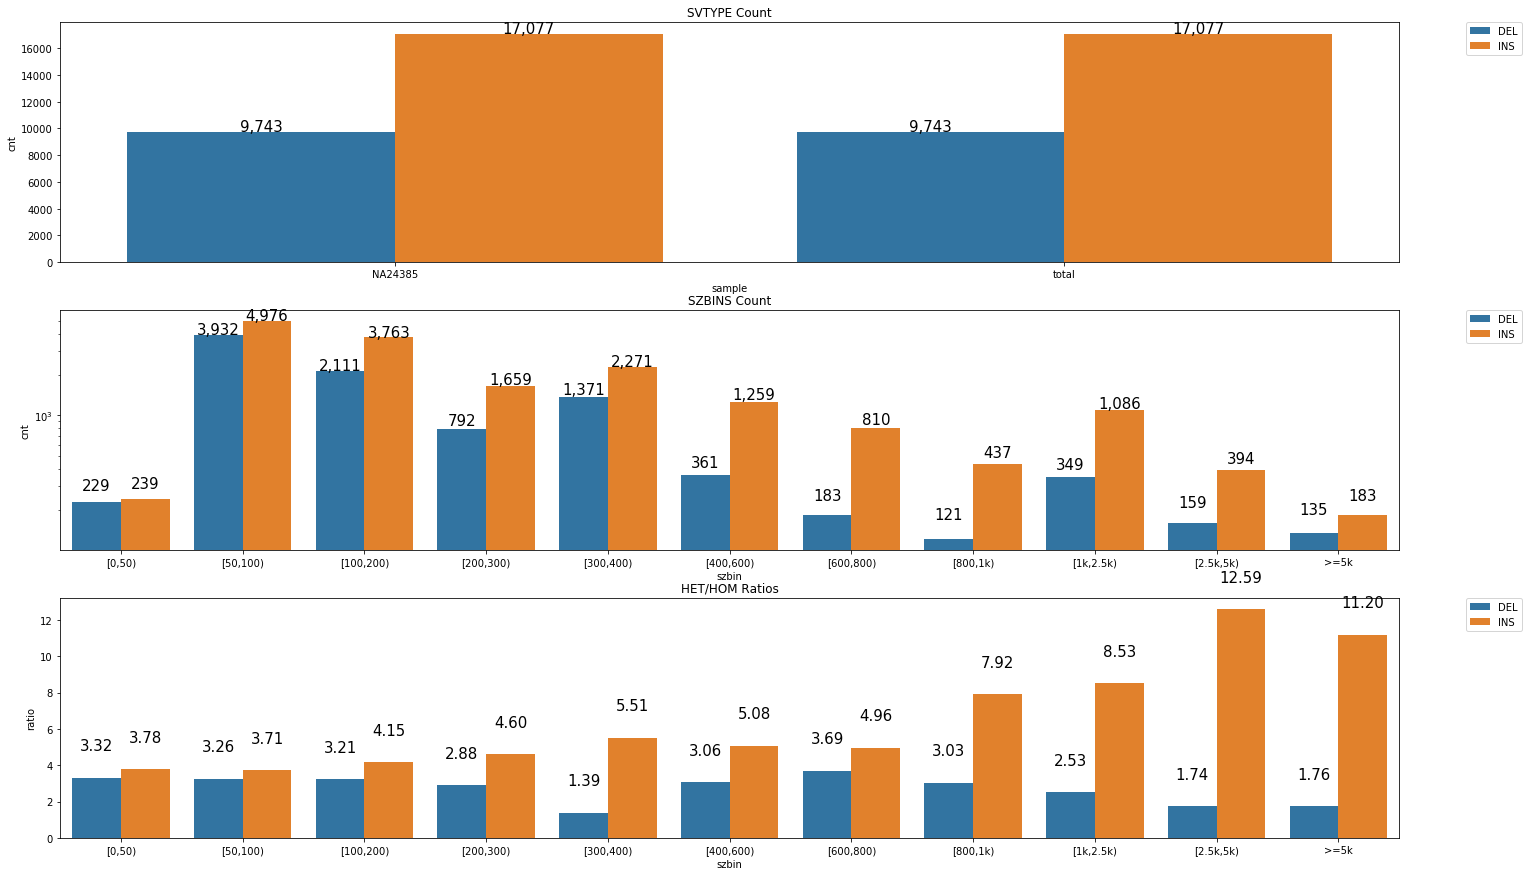

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1, figsize=(24,15))

# Per Sample SV Counts
rows = []
plt.sca(ax1)
for i in data:
    for j in ts.SV:
        if i != "total":
            rows.append([i, j.name, data[i][j.value, :, :, ts.GT.HET.value:ts.GT.HOM.value + 1].sum()])
        else:
            rows.append([i, j.name, data[i][j.value, :, :].sum()])
d = pd.DataFrame(rows, columns=["sample", "svtype", "cnt"])
chart = sb.barplot(data=d[d["cnt"] != 0], y="cnt", x="sample", hue="svtype")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
chart.set(title="SVTYPE Count")
show_values_on_bars(chart, fmt="{:,.0f}", box=False, buff=50)

# Per SizeBin SV Counts
plt.sca(ax2)
rows = []
for i in data:
    for j in ts.SV:
        for k, k_lab in enumerate(ts.SZBINS):
            if i != "total":
                rows.append([i, j.name, k_lab, data[i][j.value, k, :, ts.GT.HET.value:ts.GT.HOM.value + 1].sum()])
                
d = pd.DataFrame(rows, columns=["sample", "svtype", "szbin", "cnt"])
d["szbin"] = d["szbin"].astype(SZBINTYPE)
chart = sb.barplot(data=d[d["cnt"] != 0], y="cnt", x="szbin", hue="svtype")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
chart.set(title="SZBINS Count", yscale="log")
show_values_on_bars(chart, fmt="{:,.0f}", box=False, buff=50)

# Per SizeBin Het/Hom Ratios
plt.sca(ax3)
rows = []
for i in data:
    for j in ts.SV:
        for k, k_lab in enumerate(ts.SZBINS):
            if i != "total":
                het = data[i][j.value, k, :, ts.GT.HET.value].sum()
                hom = data[i][j.value, k, :, ts.GT.HOM.value].sum()
                rows.append([i, j.name, k_lab, het/hom])
                
d = pd.DataFrame(rows, columns=["sample", "svtype", "szbin", "ratio"])
d["szbin"] = d["szbin"].astype(SZBINTYPE)
chart = sb.barplot(data=d[~d["ratio"].isna()], y="ratio", x="szbin", hue="svtype")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
chart.set(title="HET/HOM Ratios")
show_values_on_bars(chart, fmt="{:.2f}", buff=1.5, box=False)